
#The Deep Learning Homework 3 - Question No. 07-C
Bahar Mahdavi - SN: 40152521337

# Define following Network

Dataset : is IRIS

Number Of epochs  : 2000

Weight initialize: sample from UNIF ORM distribution(low = 0, high = 1)

Split rate for Test size to Train size = 0.2

Active Functions : Leaky-Relu (0.2) for hidden layers , Softmax for output layer

Loss : Cross Entropy

Optimizer : Adam (lr:0.001)

Nodes in each hidden layer : 5

Base number of hidden layers : 3


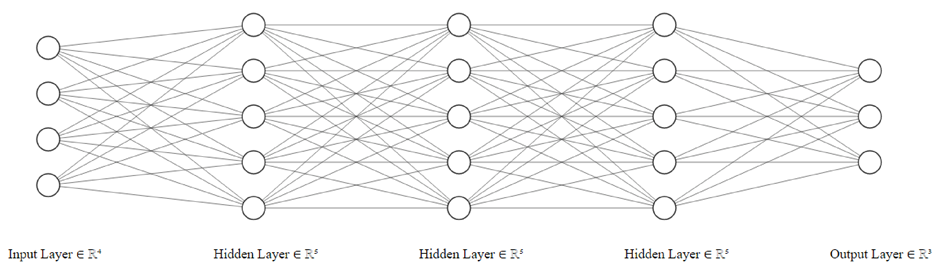

## C. design Neural network with IRIS dataset by apply the two initialization methods of Xavier initialize and He initialize and assuming the sigmoid active function instead of Leaky-Relu (0.2).

# Load Dataset

In [59]:
from sklearn import datasets

iris = datasets.load_iris()
x = iris.data
y = iris.target
print(x.shape,y.shape)

(150, 4) (150,)


# Split Train and Test data with ratio of 0.2

In [60]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=1) # splitting for train and test set
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)

(120, 4) (30, 4) (120,) (30,)


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.utils.data as td

# Create a dataset and loader for the training data
xtrain = torch.Tensor(xtrain).float()
ytrain = torch.Tensor(ytrain).long()
train_ds = utils.TensorDataset(xtrain,ytrain)
train_loader = td.DataLoader(train_ds, batch_size=10,shuffle=True)

# Create a dataset and loader for the test data
xtest = torch.Tensor(xtest).float()
ytest = torch.Tensor(ytest).long()
test_ds = utils.TensorDataset(xtest,ytest)
test_loader = td.DataLoader(test_ds, batch_size=10, shuffle=True)

## Define Network

In [62]:
class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()

        self.fc1 = nn.Linear(in_features=4, out_features=5, bias=False)
        self.activation1 = nn.Sigmoid()

        self.fc2 = nn.Linear(in_features=5, out_features=5, bias=False)
        self.activation2 = nn.Sigmoid()

        self.fc3 = nn.Linear(in_features=5, out_features=5, bias=False)
        self.activation3 = nn.Sigmoid()

        self.fc4 = nn.Linear(in_features=5, out_features=5, bias=False)
        self.activation4 = nn.Sigmoid()

        self.fc5 = nn.Linear(in_features=5, out_features=3, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)

        x = self.fc2(x)
        x = self.activation2(x)

        x = self.fc3(x)
        x = self.activation3(x)

        x = self.fc4(x)
        x = self.activation4(x)

        out = self.softmax(x)

        return out

model = IrisModel()

In [63]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [64]:
from torchsummary import summary

summary(model,(150,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 150, 5]              20
           Sigmoid-2               [-1, 150, 5]               0
            Linear-3               [-1, 150, 5]              25
           Sigmoid-4               [-1, 150, 5]               0
            Linear-5               [-1, 150, 5]              25
           Sigmoid-6               [-1, 150, 5]               0
            Linear-7               [-1, 150, 5]              25
           Sigmoid-8               [-1, 150, 5]               0
           Softmax-9               [-1, 150, 5]               0
Total params: 95
Trainable params: 95
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
-----------------------------------------------------

# 1. Xavier Initialize (Normal)



In [65]:
def weights_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv2d') != -1:
        module.weight.data.normal_(0.0, 0.02)
    elif classname.find('Norm') != -1:
        module.weight.data.normal_(1.0, 0.02)
        module.bias.data.fill_(0)

def weights_init_uniform(module):
    classname = module.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        module.weight.data.uniform_(0.0, 1.0)
        module.bias.data.fill_(0)

def init_weights(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.xavier_normal_(module.weight)  #kaiming_normal_ #kaiming_uniform_  #xavier_normal #xavier_uniform
        if module.bias is not None:  # Add a check for bias existence
           module.bias.data.fill_(0.01)

In [66]:
def train(model, data_loader, data_loader1, criterion, optimizer):
    model.train()
    model.apply(init_weights) #weights_init_uniform #init_weights
    train_loss = 0
    test_loss = 0

    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        train_loss += loss.item()
        # backpropagate
        loss.backward()
        optimizer.step()
        #train_loss += loss.item()

    ## evaluation part
    model.eval()
    for batch1, tensor1 in enumerate(data_loader1):
        data1, target1 = tensor1
        output = model(data1)
        loss1 = criterion(output, target1)
        test_loss += loss1.item()


    #Return loss
    avg_loss = train_loss / len(data_loader.dataset)
    avg_loss1 = test_loss/len(data_loader1.dataset)
    return avg_loss, avg_loss1



def test(model, data_loader,criterion):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch, tensor in enumerate(data_loader):
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += criterion(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()

    # return Test loss and prediction accuracy for the epoch
    avg_accuracy = correct / len(data_loader.dataset)
    avg_loss = test_loss / len(data_loader.dataset)

    return avg_loss, avg_accuracy

In [67]:
epochs=2000

epoch_nums = []
training_loss = []
validation_loss = []
acc_avg =[]
loss_avg=[]

for epoch in range(1, epochs):

    # Feed the training data into the model to optimize the weights
    train_loss, test_loss = train(model, train_loader, test_loader, criterion, optimizer)
    avg_loss, avg_accuracy = test (model, test_loader, criterion)
    # Log the metrcs for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    loss_avg.append(avg_loss)
    acc_avg.append(avg_accuracy)


    if epoch%200 == 199:
        print('Epoch {:d}: Training loss= {:.4f}, Test loss= {:.4f}'.format(epoch, train_loss, test_loss))
        print('Epoch {:d}: Average loss= {:.4f}, Accuracy= {:.4f}'.format(epoch, avg_loss, avg_accuracy))

Epoch 199: Training loss= 0.1601, Test loss= 0.1605
Epoch 199: Average loss= 0.1605, Accuracy= 0.2000
Epoch 399: Training loss= 0.1618, Test loss= 0.1620
Epoch 399: Average loss= 0.1620, Accuracy= 0.0000
Epoch 599: Training loss= 0.1606, Test loss= 0.1595
Epoch 599: Average loss= 0.1595, Accuracy= 0.3667
Epoch 799: Training loss= 0.1608, Test loss= 0.1608
Epoch 799: Average loss= 0.1608, Accuracy= 0.0000
Epoch 999: Training loss= 0.1596, Test loss= 0.1594
Epoch 999: Average loss= 0.1594, Accuracy= 0.3667
Epoch 1199: Training loss= 0.1609, Test loss= 0.1611
Epoch 1199: Average loss= 0.1611, Accuracy= 0.0000
Epoch 1399: Training loss= 0.1612, Test loss= 0.1608
Epoch 1399: Average loss= 0.1608, Accuracy= 0.0000
Epoch 1599: Training loss= 0.1607, Test loss= 0.1605
Epoch 1599: Average loss= 0.1605, Accuracy= 0.0000
Epoch 1799: Training loss= 0.1609, Test loss= 0.1612
Epoch 1799: Average loss= 0.1612, Accuracy= 0.3667
Epoch 1999: Training loss= 0.1624, Test loss= 0.1614
Epoch 1999: Average l

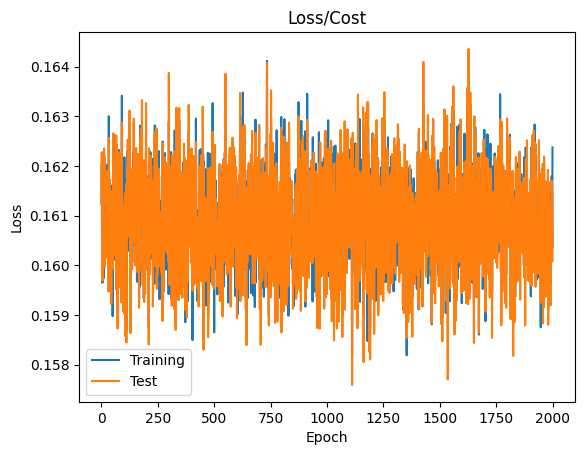

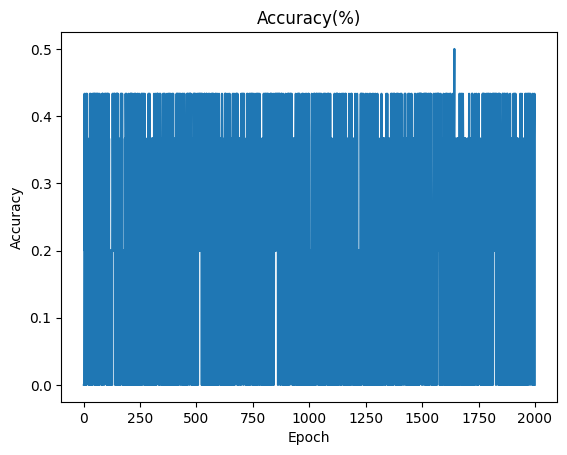

<Figure size 640x480 with 0 Axes>

In [68]:
from matplotlib import pyplot as plt

plt.subplot(1,1,1)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss/Cost')
plt.legend(['Training', 'Test'], loc='best')
plt.show()

plt.subplot(1,1,1)
plt.plot(epoch_nums, acc_avg)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy(%)')
plt.show()

plt.suptitle('IrisModel')
plt.tight_layout()
plt.show()

# 2. Xavier Initialize (Uniform)

In [69]:
def weights_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv2d') != -1:
        module.weight.data.normal_(0.0, 0.02)
    elif classname.find('Norm') != -1:
        module.weight.data.normal_(1.0, 0.02)
        module.bias.data.fill_(0)

def weights_init_uniform(module):
    classname = module.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        module.weight.data.uniform_(0.0, 1.0)
        module.bias.data.fill_(0)

def init_weights(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)  #kaiming_normal_ #kaiming_uniform_  #xavier_normal #xavier_uniform
        if module.bias is not None:  # Add a check for bias existence
           module.bias.data.fill_(0.01)

In [70]:
def train(model, data_loader, data_loader1, criterion, optimizer):
    model.train()
    model.apply(init_weights) #weights_init_uniform #init_weights
    train_loss = 0
    test_loss = 0

    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        train_loss += loss.item()
        # backpropagate
        loss.backward()
        optimizer.step()
        #train_loss += loss.item()

    ## evaluation part
    model.eval()
    for batch1, tensor1 in enumerate(data_loader1):
        data1, target1 = tensor1
        output = model(data1)
        loss1 = criterion(output, target1)
        test_loss += loss1.item()


    #Return loss
    avg_loss = train_loss / len(data_loader.dataset)
    avg_loss1 = test_loss/len(data_loader1.dataset)
    return avg_loss, avg_loss1



def test(model, data_loader,criterion):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch, tensor in enumerate(data_loader):
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += criterion(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()

    # return Test loss and prediction accuracy for the epoch
    avg_accuracy = correct / len(data_loader.dataset)
    avg_loss = test_loss / len(data_loader.dataset)

    return avg_loss, avg_accuracy

In [71]:
epochs=2000

epoch_nums = []
training_loss = []
validation_loss = []
acc_avg =[]
loss_avg=[]

for epoch in range(1, epochs):

    # Feed the training data into the model to optimize the weights
    train_loss, test_loss = train(model, train_loader, test_loader, criterion, optimizer)
    avg_loss, avg_accuracy = test (model, test_loader, criterion)
    # Log the metrcs for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    loss_avg.append(avg_loss)
    acc_avg.append(avg_accuracy)


    if epoch%200 == 199:
        print('Epoch {:d}: Training loss= {:.4f}, Test loss= {:.4f}'.format(epoch, train_loss, test_loss))
        print('Epoch {:d}: Average loss= {:.4f}, Accuracy= {:.4f}'.format(epoch, avg_loss, avg_accuracy))

Epoch 199: Training loss= 0.1615, Test loss= 0.1618
Epoch 199: Average loss= 0.1618, Accuracy= 0.0000
Epoch 399: Training loss= 0.1613, Test loss= 0.1618
Epoch 399: Average loss= 0.1618, Accuracy= 0.0000
Epoch 599: Training loss= 0.1606, Test loss= 0.1602
Epoch 599: Average loss= 0.1602, Accuracy= 0.4333
Epoch 799: Training loss= 0.1598, Test loss= 0.1601
Epoch 799: Average loss= 0.1601, Accuracy= 0.2000
Epoch 999: Training loss= 0.1619, Test loss= 0.1617
Epoch 999: Average loss= 0.1617, Accuracy= 0.3667
Epoch 1199: Training loss= 0.1637, Test loss= 0.1635
Epoch 1199: Average loss= 0.1635, Accuracy= 0.0000
Epoch 1399: Training loss= 0.1616, Test loss= 0.1611
Epoch 1399: Average loss= 0.1611, Accuracy= 0.0000
Epoch 1599: Training loss= 0.1604, Test loss= 0.1611
Epoch 1599: Average loss= 0.1611, Accuracy= 0.3667
Epoch 1799: Training loss= 0.1613, Test loss= 0.1616
Epoch 1799: Average loss= 0.1616, Accuracy= 0.0000
Epoch 1999: Training loss= 0.1613, Test loss= 0.1616
Epoch 1999: Average l

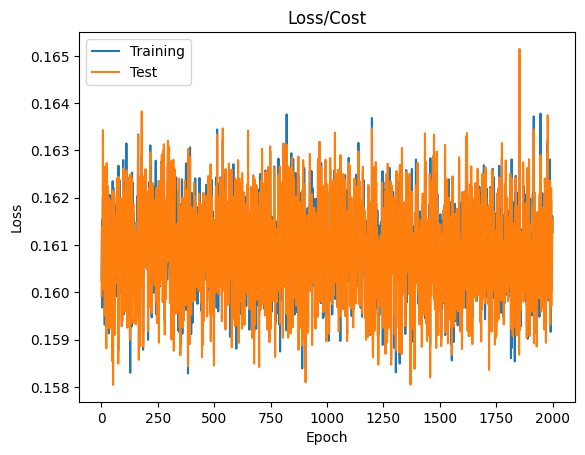

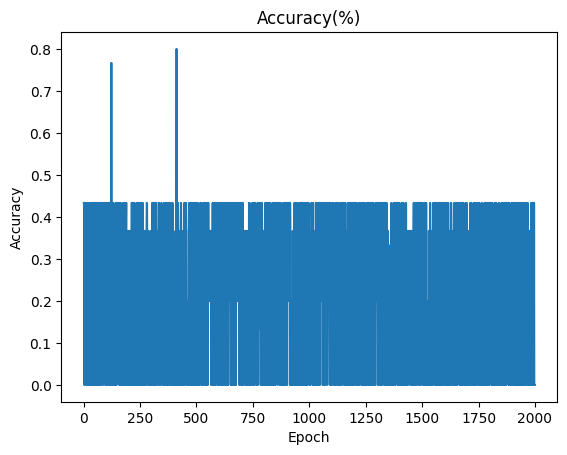

<Figure size 640x480 with 0 Axes>

In [72]:
from matplotlib import pyplot as plt

plt.subplot(1,1,1)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss/Cost')
plt.legend(['Training', 'Test'], loc='best')
plt.show()

plt.subplot(1,1,1)
plt.plot(epoch_nums, acc_avg)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy(%)')
plt.show()

plt.suptitle('IrisModel')
plt.tight_layout()
plt.show()

# 3. He Initialize (Normal)

In [73]:
def weights_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv2d') != -1:
        module.weight.data.normal_(0.0, 0.02)
    elif classname.find('Norm') != -1:
        module.weight.data.normal_(1.0, 0.02)
        module.bias.data.fill_(0)

def weights_init_uniform(module):
    classname = module.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        module.weight.data.uniform_(0.0, 1.0)
        module.bias.data.fill_(0)

def init_weights(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.kaiming_normal_(module.weight)  #kaiming_normal_ #kaiming_uniform_  #xavier_normal #xavier_uniform
        if module.bias is not None:  # Add a check for bias existence
           module.bias.data.fill_(0.01)

In [74]:
def train(model, data_loader, data_loader1, criterion, optimizer):
    model.train()
    model.apply(init_weights) #weights_init_uniform #init_weights
    train_loss = 0
    test_loss = 0

    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        train_loss += loss.item()
        # backpropagate
        loss.backward()
        optimizer.step()
        #train_loss += loss.item()

    ## evaluation part
    model.eval()
    for batch1, tensor1 in enumerate(data_loader1):
        data1, target1 = tensor1
        output = model(data1)
        loss1 = criterion(output, target1)
        test_loss += loss1.item()


    #Return loss
    avg_loss = train_loss / len(data_loader.dataset)
    avg_loss1 = test_loss/len(data_loader1.dataset)
    return avg_loss, avg_loss1



def test(model, data_loader,criterion):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch, tensor in enumerate(data_loader):
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += criterion(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()

    # return Test loss and prediction accuracy for the epoch
    avg_accuracy = correct / len(data_loader.dataset)
    avg_loss = test_loss / len(data_loader.dataset)

    return avg_loss, avg_accuracy

In [75]:
epochs=2000

epoch_nums = []
training_loss = []
validation_loss = []
acc_avg =[]
loss_avg=[]

for epoch in range(1, epochs):

    # Feed the training data into the model to optimize the weights
    train_loss, test_loss = train(model, train_loader, test_loader, criterion, optimizer)
    avg_loss, avg_accuracy = test (model, test_loader, criterion)
    # Log the metrcs for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    loss_avg.append(avg_loss)
    acc_avg.append(avg_accuracy)


    if epoch%200 == 199:
        print('Epoch {:d}: Training loss= {:.4f}, Test loss= {:.4f}'.format(epoch, train_loss, test_loss))
        print('Epoch {:d}: Average loss= {:.4f}, Accuracy= {:.4f}'.format(epoch, avg_loss, avg_accuracy))

Epoch 199: Training loss= 0.1628, Test loss= 0.1626
Epoch 199: Average loss= 0.1626, Accuracy= 0.0000
Epoch 399: Training loss= 0.1603, Test loss= 0.1599
Epoch 399: Average loss= 0.1599, Accuracy= 0.4333
Epoch 599: Training loss= 0.1629, Test loss= 0.1630
Epoch 599: Average loss= 0.1630, Accuracy= 0.0000
Epoch 799: Training loss= 0.1604, Test loss= 0.1592
Epoch 799: Average loss= 0.1592, Accuracy= 0.4333
Epoch 999: Training loss= 0.1609, Test loss= 0.1609
Epoch 999: Average loss= 0.1609, Accuracy= 0.0000
Epoch 1199: Training loss= 0.1593, Test loss= 0.1597
Epoch 1199: Average loss= 0.1597, Accuracy= 0.2000
Epoch 1399: Training loss= 0.1622, Test loss= 0.1607
Epoch 1399: Average loss= 0.1607, Accuracy= 0.4333
Epoch 1599: Training loss= 0.1615, Test loss= 0.1613
Epoch 1599: Average loss= 0.1613, Accuracy= 0.0000
Epoch 1799: Training loss= 0.1615, Test loss= 0.1615
Epoch 1799: Average loss= 0.1615, Accuracy= 0.0000
Epoch 1999: Training loss= 0.1626, Test loss= 0.1630
Epoch 1999: Average l

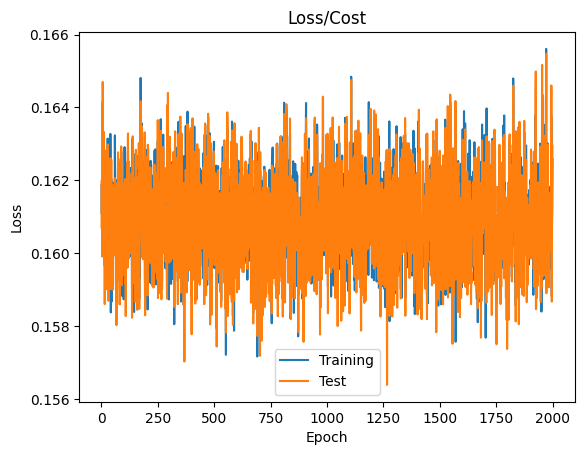

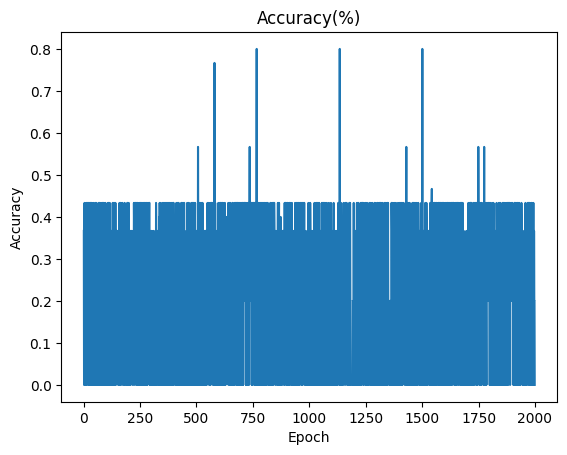

<Figure size 640x480 with 0 Axes>

In [76]:
from matplotlib import pyplot as plt

plt.subplot(1,1,1)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss/Cost')
plt.legend(['Training', 'Test'], loc='best')
plt.show()

plt.subplot(1,1,1)
plt.plot(epoch_nums, acc_avg)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy(%)')
plt.show()

plt.suptitle('IrisModel')
plt.tight_layout()
plt.show()

# 4. He Initialize (Uniform)

In [77]:
def weights_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv2d') != -1:
        module.weight.data.normal_(0.0, 0.02)
    elif classname.find('Norm') != -1:
        module.weight.data.normal_(1.0, 0.02)
        module.bias.data.fill_(0)

def weights_init_uniform(module):
    classname = module.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        module.weight.data.uniform_(0.0, 1.0)
        module.bias.data.fill_(0)

def init_weights(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.kaiming_uniform_(module.weight)  #kaiming_normal_ #kaiming_uniform_  #xavier_normal #xavier_uniform
        if module.bias is not None:  # Add a check for bias existence
           module.bias.data.fill_(0.01)

In [78]:
def train(model, data_loader, data_loader1, criterion, optimizer):
    model.train()
    model.apply(init_weights) #weights_init_uniform #init_weights
    train_loss = 0
    test_loss = 0

    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        train_loss += loss.item()
        # backpropagate
        loss.backward()
        optimizer.step()
        #train_loss += loss.item()

    ## evaluation part
    model.eval()
    for batch1, tensor1 in enumerate(data_loader1):
        data1, target1 = tensor1
        output = model(data1)
        loss1 = criterion(output, target1)
        test_loss += loss1.item()


    #Return loss
    avg_loss = train_loss / len(data_loader.dataset)
    avg_loss1 = test_loss/len(data_loader1.dataset)
    return avg_loss, avg_loss1



def test(model, data_loader,criterion):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch, tensor in enumerate(data_loader):
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += criterion(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()

    # return Test loss and prediction accuracy for the epoch
    avg_accuracy = correct / len(data_loader.dataset)
    avg_loss = test_loss / len(data_loader.dataset)

    return avg_loss, avg_accuracy

In [79]:
epochs=2000

epoch_nums = []
training_loss = []
validation_loss = []
acc_avg =[]
loss_avg=[]

for epoch in range(1, epochs):

    # Feed the training data into the model to optimize the weights
    train_loss, test_loss = train(model, train_loader, test_loader, criterion, optimizer)
    avg_loss, avg_accuracy = test (model, test_loader, criterion)
    # Log the metrcs for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    loss_avg.append(avg_loss)
    acc_avg.append(avg_accuracy)


    if epoch%200 == 199:
        print('Epoch {:d}: Training loss= {:.4f}, Test loss= {:.4f}'.format(epoch, train_loss, test_loss))
        print('Epoch {:d}: Average loss= {:.4f}, Accuracy= {:.4f}'.format(epoch, avg_loss, avg_accuracy))

Epoch 199: Training loss= 0.1615, Test loss= 0.1629
Epoch 199: Average loss= 0.1629, Accuracy= 0.2000
Epoch 399: Training loss= 0.1600, Test loss= 0.1587
Epoch 399: Average loss= 0.1587, Accuracy= 0.4333
Epoch 599: Training loss= 0.1611, Test loss= 0.1603
Epoch 599: Average loss= 0.1603, Accuracy= 0.3667
Epoch 799: Training loss= 0.1611, Test loss= 0.1626
Epoch 799: Average loss= 0.1626, Accuracy= 0.2000
Epoch 999: Training loss= 0.1598, Test loss= 0.1596
Epoch 999: Average loss= 0.1596, Accuracy= 0.4333
Epoch 1199: Training loss= 0.1603, Test loss= 0.1610
Epoch 1199: Average loss= 0.1610, Accuracy= 0.2000
Epoch 1399: Training loss= 0.1599, Test loss= 0.1596
Epoch 1399: Average loss= 0.1596, Accuracy= 0.4333
Epoch 1599: Training loss= 0.1612, Test loss= 0.1611
Epoch 1599: Average loss= 0.1611, Accuracy= 0.4333
Epoch 1799: Training loss= 0.1617, Test loss= 0.1610
Epoch 1799: Average loss= 0.1610, Accuracy= 0.0000
Epoch 1999: Training loss= 0.1625, Test loss= 0.1613
Epoch 1999: Average l

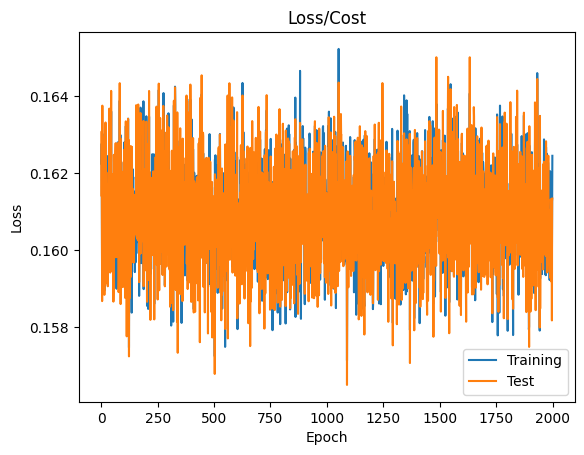

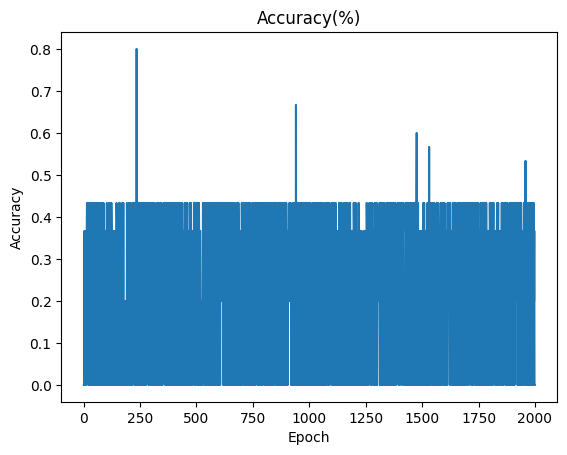

<Figure size 640x480 with 0 Axes>

In [80]:
from matplotlib import pyplot as plt

plt.subplot(1,1,1)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss/Cost')
plt.legend(['Training', 'Test'], loc='best')
plt.show()

plt.subplot(1,1,1)
plt.plot(epoch_nums, acc_avg)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy(%)')
plt.show()

plt.suptitle('IrisModel')
plt.tight_layout()
plt.show()